In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import yfinance as yf
import backtrader as bt
import backtrader.analyzers as btanalyzers

In [57]:
ticker = yf.Ticker("BTC-USD")
ticker

yfinance.Ticker object <BTC-USD>

In [175]:
df = ticker.history(start='2021-02-19', end='2022-02-19', interval='1d')
df = df.reindex(index=df.index[::-1])
df.reset_index(level=0, inplace=True)
df.rename(
{
    'Date':'date',
    'Open':'open',
    'High':'high',
    'Low': 'low',
    'Close': 'close',
    'Volume':'volume',
    'Dividends': 'dividend',
    'Stock Splits':'stock splits'
    
},axis=1, inplace=True
)

df.head()

,date,open,high,low,close,volume,dividend,stock splits
0,2022-02-18,40552.132812,40929.152344,39637.617188,40030.976562,23310007704,0,0
1,2022-02-17,43937.070312,44132.972656,40249.371094,40538.011719,26246662813,0,0
2,2022-02-16,44578.277344,44578.277344,43456.691406,43961.859375,19792547657,0,0
3,2022-02-15,42586.464844,44667.218750,42491.035156,44575.203125,22721659051,0,0
4,2022-02-14,42157.398438,42775.777344,41681.957031,42586.917969,20827783012,0,0


In [202]:
class MeanReversion:
    def __init__(self, ma, period):
        self.ma = ma 
        self.period = period
    
    def moving_average(self):
        df['ma']= df['close'].rolling(self.ma).mean()
        
    def bollinger(self):
        df['std'] = df['close'].rolling(self.ma).std()
        df['upper_bollinger'] = df['ma'] + (0.5) * df['std']
        df['lower_bollinger'] = df['ma'] - (0.5) * df['std']
        

    def rsi(self):
       
        def gain(value):
            if value < 0:
                return 0
            else:
                return value
    
        def loss(value):
            if value > 0:
                return 0
            else:
                return abs(value)
            
        #Calculate price delta / difference between current and previous row
        
        df['delta'] = df['close'].diff()
        
        #Classify delta into gain & loss

        df['gain'] = df['delta'].apply(lambda x:gain(x))
        df['loss'] = df['delta'].apply(lambda x:loss(x))
        
        #Calculate ema (provides exponentially weighted calculations - older observations are given lesser weight)

        df['ema_gain'] = df['gain'].ewm(self.period).mean()
        df['ema_loss'] = df['loss'].ewm(self.period).mean()

        #Calculate RSI

        df['rs'] = df['ema_gain']/df['ema_loss']
        df['rsi'] = df['rs'].apply(lambda x: 100 - (100/(x+1)))
        
    def strategy(self):
        #buy signal
        df['signal'] = np.where(
            (df['rsi'] < 30) &
            (df['close'] < df['lower_bollinger']), 1, np.nan) #nan acts as a placeholder for any missing numerical value

        #sell signal
        df['signal'] = np.where(
            (df['rsi'] > 70) & 
            (df['close'] > df['upper_bollinger']), -1, df['signal'])

        #buy/sell next trading day
        df['signal'] = df['signal'].shift()
        df['signal'] = df['signal'].fillna(0) #sell then you're flat = 0


### Initiate functions

In [203]:
ma = MeanReversion(ma=20, period=5)
ma.moving_average()
ma.bollinger()
ma.rsi()
ma.strategy()

In [204]:
df.head(1)

,date,open,high,low,close,volume,dividend,stock splits,ma,std,upper_bollinger,lower_bollinger,delta,gain,loss,ema_gain,ema_loss,rs,rsi,signal
0,2022-02-18,40552.132812,40929.152344,39637.617188,40030.976562,23310007704,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### Plot

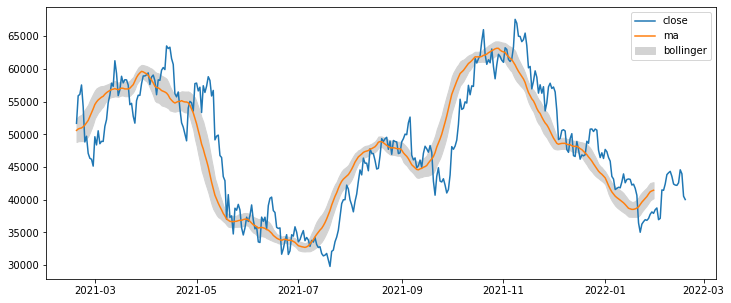

In [205]:
plt.figure(figsize=(12,5))

plt.plot(df['date'],df['close'], label='close')
plt.plot(df['date'],df['ma'], label='ma')
plt.fill_between(df['date'],df['upper_bollinger'], df['lower_bollinger'], color ='lightgrey', label='bollinger')

plt.legend();


### RSI

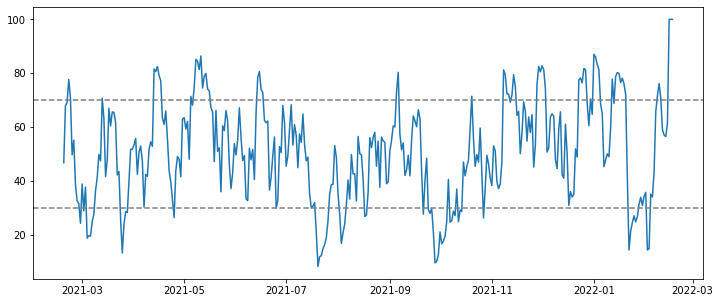

In [206]:
#rsi tolerance
upper_rsi = 70
lower_rsi = 30

plt.figure(figsize=(12,5))

plt.plot(df['date'],df['rsi'])
plt.axhline(lower_rsi, c=(.5,.5,.5), ls='--')
plt.axhline(upper_rsi, c=(.5,.5,.5), ls='--')


### Backtesting